In [1]:
import numpy as np # библиотека работы с массивами
import pandas as pd # библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model, load_model # последовательная и функциональная модели
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop # оптимайзеры
from tensorflow.keras.preprocessing.text import Tokenizer # преобразование текстов в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # дополнить нулями вектор
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # подключаем колбэки
from tensorflow.keras.metrics import Precision, Recall # метрики

from sklearn.preprocessing import LabelEncoder, StandardScaler # перевод в категориальные данные и стандартизация данных
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
from tensorflow.keras.utils import plot_model, to_categorical # вывод схемы модели
import pickle                   # для загрузки-сохранения обьектов
import matplotlib.pyplot as plt # для графиков

# Предобработка, создание енкодеров и токенайзеров

In [ ]:
# функция сохранения объекта
def save_obj(obj_to_save, filename):
  with open(filename, 'wb') as f:
    pickle.dump(obj_to_save, f, protocol=pickle.HIGHEST_PROTOCOL) # saving
    
# функция загрузки обьекта
def load_obj(filename):
  with open(filename, 'rb') as f:
    return pickle.load(f) # loading
    
# категориальные и числовые столбцы
object_cols = ['district', 'street', 'house_floor', 'planning', 'rooms']
numeric_cols = ['area1', 'area2', 'price']
text_cols = ['comment']
all_cols = object_cols + numeric_cols + text_cols

In [ ]:
# прочитаем файл
df = pd.read_csv('http://m.ufamax.eu:8080/belka/citystar-parsed.csv') # загружаем со своего сервера
df.head()

,district,street,house_floor,planning,rooms,area1,area2,price,comment
0,Ленинский,Куйбышева,1,раздельная,3,57.0,35.0,2850,Трехкомнатная квартира нестандартной планировк...
1,Орджоникидзевский,50-летия Магнитки,3,нестандартная,3,98.5,60.0,6990,Продам трехкомнатную квартиру 100кв.м. Простор...
2,Ленинский,Менделеева,3,старой планировки,3,83.0,55.0,5100,ПРОДАМ трехкомнатную квартиру старой планировк...
3,Правобережный,Ленина пр-т,7,малосемейка,1,30.4,17.0,1790,Квартира малосемейка в хорошем состоянии. П...
4,Ленинский,Ленина пр-т,5,-,3,77.0,48.0,3990,КВАРТИРА СТАРОЙ ПЛАНИРОВКИ С ВЫСОКИМИ ПОТОЛКА...


In [ ]:
# посмотрим структуру и типы столбцов
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   district     880 non-null    object 
 1   street       874 non-null    object 
 2   house_floor  880 non-null    int64  
 3   planning     880 non-null    object 
 4   rooms        880 non-null    int64  
 5   area1        880 non-null    float64
 6   area2        880 non-null    float64
 7   price        880 non-null    int64  
 8   comment      880 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 62.0+ KB


In [ ]:
# проходим LabelEncoder по категориальным данным
for col in object_cols:
  le = LabelEncoder() # создаем енкодер для категорий
  le.fit(df[col].astype(str)) # обучаем 
  save_obj(le, col) # сохраним энкодер для столбца

In [ ]:
# проходим StandardScaler по числовым данным
for col in numeric_cols:
  ss = StandardScaler() # создаём нормировщик нормальным распределением
  ss.fit(df[col].values.reshape(-1,1)) # обучаем
  save_obj(ss, col) # сохраним энкодер для столбца

In [ ]:
# создаем токенайзер и обучаем его на всех комментариях
tokenizer = Tokenizer(num_words=10000, # количество слов для словаря # в базе 6778 слов
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', # фильтр текста
                      lower=True, # нижний регистр
                      split=' ', # разделить пробелом
                      oov_token='unknown', # обозначим слова вне словаря
                      char_level=False # токенизируем по словам
                      )
tokenizer.fit_on_texts(df['comment'].tolist()) # обучаем и проходим по обучающей выборке
save_obj(tokenizer, 'comment') # сохраним токенайзер

# Загрузка данных

In [ ]:
# загрузим все LabelEncoder и StandardScaler
district = load_obj('district')
street = load_obj('street')
house_floor = load_obj('house_floor')
planning = load_obj('planning')
rooms = load_obj('rooms')
area1 = load_obj('area1')
area2 = load_obj('area2')
price = load_obj('price')
# загрузим токенайзер
tokenizer = load_obj('comment')

In [ ]:
# взглянем на исходные данные еще раз
df.head(1)

,district,street,house_floor,planning,rooms,area1,area2,price,comment
0,Ленинский,Куйбышева,1,раздельная,3,57.0,35.0,2850,Трехкомнатная квартира нестандартной планировк...


In [ ]:
# a = district.transform([ df['district'][0] ])[0]
# print(a)

# nClasses = len(district.classes_)
# b = to_categorical(a, nClasses)
# print(list(b))

In [ ]:
# a = area1.transform(np.array( df['area1'][0] ).reshape(-1,1))[0][0]
# a

In [ ]:
# a = tokenizer.texts_to_sequences([ df['comment'][0] ])[0]
# print(a)

# b = tokenizer.sequences_to_matrix([ a ])[0]
# print(b)

In [ ]:
########## категориальные данные ############

# функция преобразования района в формат для подачи в нейронку
def pack_district(d):
  d = str(d) # конвертирум в строку
  t = district.transform([ d ])[0] # берем категорию
  n = len(district.classes_) # число классов этого столбца
  l = to_categorical(t, n) # превращаем токен в One-Hot Encoding
  return list(l) # возвращаем в виде списка в формате One-Hot Encoding

# функция преобразования улицы в формат для подачи в нейронку
def pack_street(d):
  d = str(d) # конвертирум в строку
  t = street.transform([ d ])[0] # берем категорию
  n = len(street.classes_) # число классов этого столбца
  l = to_categorical(t, n) # превращаем токен в One-Hot Encoding
  return list(l) # возвращаем в виде списка в формате One-Hot Encoding

# функция преобразования этажа в формат для подачи в нейронку
def pack_house_floor(d):
  d = str(d) # конвертирум в строку
  t = house_floor.transform([ d ])[0] # берем категорию
  n = len(house_floor.classes_) # число классов этого столбца
  l = to_categorical(t, n) # превращаем токен в One-Hot Encoding
  return list(l) # возвращаем в виде списка в формате One-Hot Encoding

# функция преобразования планировки в формат для подачи в нейронку
def pack_planning(d):
  d = str(d) # конвертирум в строку
  t = planning.transform([ d ])[0] # берем категорию
  n = len(planning.classes_) # число классов этого столбца
  l = to_categorical(t, n) # превращаем токен в One-Hot Encoding
  return list(l) # возвращаем в виде списка в формате One-Hot Encoding

# функция преобразования комнат в формат для подачи в нейронку
def pack_rooms(d):
  d = str(d) # конвертирум в строку
  t = rooms.transform([ d ])[0] # берем категорию
  n = len(rooms.classes_) # число классов этого столбца
  l = to_categorical(t, n) # превращаем токен в One-Hot Encoding
  return list(l) # возвращаем в виде списка в формате One-Hot Encoding

########## числовые данные ############

# функция преобразования area1 в формат для подачи в нейронку
def pack_area1(d):
  try:
    d = float(d) # конвертирум во float
  except:
    d = 0.0 # при ошибке подаем 0
  r = area1.transform(np.array( d ).reshape(-1,1))[0][0] # нормализуем по скалеру для этого столбца
  return r # возвращаем в виде числа float

# функция преобразования area2 в формат для подачи в нейронку
def pack_area2(d):
  try:
    d = float(d) # конвертирум во float
  except:
    d = 0.0 # при ошибке подаем 0
  r = area2.transform(np.array( d ).reshape(-1,1))[0][0] # нормализуем по скалеру для этого столбца
  return r # возвращаем в виде числа float

# функция преобразования price в формат для подачи в нейронку
def pack_price(d):
  try:
    d = float(d) # конвертирум во float
  except:
    d = 0.0 # при ошибке подаем 0
  r = price.transform(np.array( d ).reshape(-1,1))[0][0] # нормализуем по скалеру для этого столбца
  return r # возвращаем в виде числа float

########## текстовые данные ############

# функция преобразования текста в вектор Bag-of-Words
def pack_comment(d):
  d = str(d) # конвертирум в строку
  t = tokenizer.texts_to_sequences([ d ])[0] # превращаем слова в токены
  l = tokenizer.sequences_to_matrix([ t ])[0] # превращаем в вектор BoF
  return list(l) # вовзращаем списком вектор BoF

# функция сборки вектора для подачи в модель
def get_all_parameters(*args):
  out = [] # здесь будут все параметры в ряд
  for c in args:
    if isinstance(c, float) or isinstance(c, int):
      out.append(c) # добавить append в список
    if isinstance(c, list):
      out.extend(c) # дополнить extend список
  return out # вернем список

# функция оценки качества модели на валидационном наборе с учетом нормирования данных
def eval_model(model, data):
  pred = model.predict(data, verbose=0) # получаем выход сети на проверочно выборке
  predUnscaled = price.inverse_transform(pred.reshape(-1, 1)).flatten() # делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = price.inverse_transform(y_val.reshape(-1, 1)).flatten() # делаем такое же обратное нормирование y_val к базовым ценам
  delta = predUnscaled - yTrainUnscaled # считаем разность предсказания и правильных цен
  absDelta = abs(delta) # берём модуль отклонения
  print("Модуль ошибки", round(sum(absDelta) / (len(absDelta)),3)) # выводим усреднённую ошибку

# функция предикта цены
def get_price(model, district, street, house_floor, planning, rooms, area1, area2, comment):
  # собираем входные данные с помощью get_all_parameters()
  x_data = [get_all_parameters(pack_district(district),\
                              pack_street(street),\
                              pack_house_floor(house_floor),\
                              pack_planning(planning),\
                              pack_rooms(rooms),\
                              pack_area1(area1),\
                              pack_area2(area2),\
                              pack_comment(comment))]
  x_data = np.array(x_data) # переводим в numpy
  pred = model.predict(x_data, verbose=0) # делаем прогноз
  predUnscaled = price.inverse_transform(pred.reshape(-1, 1)).flatten()
  return str(round(predUnscaled[0],0)) # вернем окргулив в формате str

In [ ]:
# взглянем на исходные данные еще раз
df.head(3)

,district,street,house_floor,planning,rooms,area1,area2,price,comment
0,Ленинский,Куйбышева,1,раздельная,3,57.0,35.0,2850,Трехкомнатная квартира нестандартной планировк...
1,Орджоникидзевский,50-летия Магнитки,3,нестандартная,3,98.5,60.0,6990,Продам трехкомнатную квартиру 100кв.м. Простор...
2,Ленинский,Менделеева,3,старой планировки,3,83.0,55.0,5100,ПРОДАМ трехкомнатную квартиру старой планировк...


In [ ]:
# собираем входные данные с помощью get_all_parameters()
x_data = [get_all_parameters(pack_district(df.loc[i,'district']),\
                             pack_street(df.loc[i,'street']),\
                             pack_house_floor(df.loc[i,'house_floor']),\
                             pack_planning(df.loc[i,'planning']),\
                             pack_rooms(df.loc[i,'rooms']),\
                             pack_area1(df.loc[i,'area1']),\
                             pack_area2(df.loc[i,'area2']),\
                             pack_comment(df.loc[i,'comment']))\
          for i in range(len(df))]
x_data = np.array(x_data)

# собираем выходные данные с помощью get_all_parameters()
y_data = [pack_price(df.loc[i, 'price']) for i in range(len(df))]
y_data = np.array(y_data)

print(f'x_data: {x_data.shape}')
print(f'y_data: {y_data.shape}')

x_data: (880, 10187)
y_data: (880,)


In [ ]:
# собираем выборки
x_train, x_val, y_train, y_val = train_test_split(x_data, # вход сети
                                                  y_data, # выход сети
                                                  test_size=0.1, # валидационная выборка 10%
                                                  shuffle=True, # перемешать выборку
                                                  random_state=14, # зафиксим рандомное состояние
                                                  )
print('Выборки созданы!')
print(f'x_train: {x_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'x_val: {x_val.shape}')
print(f'y_val: {y_val.shape}')

Выборки созданы!
x_train: (792, 10187)
y_train: (792,)
x_val: (88, 10187)
y_val: (88,)


# Создаем модель

In [ ]:
# колбэки
def on_epoch_end(epoch, logs):
  pred = model.predict(x_val, verbose=0) # получаем выход сети на проверочно выборке
  predUnscaled = price.inverse_transform(pred.reshape(-1, 1)).flatten() # делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = price.inverse_transform(y_val.reshape(-1, 1)).flatten() # делаем такое же обратное нормирование y_val к базовым ценам
  delta = predUnscaled - yTrainUnscaled # считаем разность предсказания и правильных цен
  absDelta = abs(delta) # берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (len(absDelta)),3)) # выводим усреднённую ошибку

# свой колбэк на конец эпохи
pltMae = LambdaCallback(on_epoch_end=on_epoch_end) 

# колбэк сохранения лучших весов в конце каждой эпохи
checkpoint = [
             ModelCheckpoint('model.h5', 
             monitor='val_loss', 
             save_best_only=True)
             ]

# колбэк остановки обучения если за несколько последних метрика не улучшилась
early = EarlyStopping(monitor='val_loss', patience=5, mode='auto')

# колбэк уменьшения шага обучения при отсутствии улучшения метрики
lr_reduce = ReduceLROnPlateau(
                           monitor='val_loss',
                           patience=5, # 4
                           verbose=0, 
                           mode='auto'
                           )


## Модель 1 (Функциональная модель - ручная сборка)

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

0

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10187)]           0         
                                                                 
 dense_8 (Dense)             (None, 400)               4075200   
                                                                 
 dense_9 (Dense)             (None, 100)               40100     
                                                                 
 dense_10 (Dense)            (None, 10)                1010      
                                                                 
 batch_normalization (BatchN  (None, 10)               40        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                             

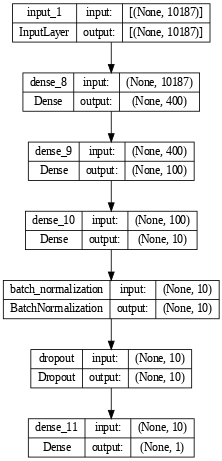

In [ ]:
input1 = Input(shape=(x_train.shape[1],)) # входной слой ветки x1
# input2 = Input(shape=(comment.shape[1],))    # входной слой ветки x2

x1 = Dense(400, activation='relu')(input1)    # ветка x1
# x2 = Dense(200, activation='relu')(input2)  # ветка x2

# x = concatenate([x1,x2])                    # объединяем две ветки
x = x1

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = BatchNormalization(momentum=0.8)(x)       # Нормализация
x = Dropout(0.2)(x)
x = Dense(1, activation='linear')(x)          # финальный нейрон

model = Model(input1, x)                      # создаем модель (указываем входы и выходы) 
# model = Model((input1,input2), x)           # создаем модель (указываем входы и выходы) 

model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae']) # компилируем

# отобразим данные модели
model.summary()
# отобразим схему модели
plot_model(model, dpi=60, show_shapes=True)

In [ ]:
# обучаем модель
history = model.fit(x_train, # обучающая выборка вход
                    y_train, # обучающая выборка выход
                    epochs=200, # эпох
                    validation_data=(x_val,   # валидационная выборка вход
                                     y_val),  # валидационная выборка выход
                    verbose=0, # без вывода статуса обучения
                    batch_size=25, # размер батча
                    callbacks=[pltMae, checkpoint, lr_reduce], # колбэки early
                    )

Эпоха 0 модуль ошибки 1048.788
Эпоха 1 модуль ошибки 907.256
Эпоха 2 модуль ошибки 837.156
Эпоха 3 модуль ошибки 859.858
Эпоха 4 модуль ошибки 870.177
Эпоха 5 модуль ошибки 793.164
Эпоха 6 модуль ошибки 759.872
Эпоха 7 модуль ошибки 751.507
Эпоха 8 модуль ошибки 739.535
Эпоха 9 модуль ошибки 720.599
Эпоха 10 модуль ошибки 717.516
Эпоха 11 модуль ошибки 690.833
Эпоха 12 модуль ошибки 715.511
Эпоха 13 модуль ошибки 649.321
Эпоха 14 модуль ошибки 669.833
Эпоха 15 модуль ошибки 670.219
Эпоха 16 модуль ошибки 658.883
Эпоха 17 модуль ошибки 680.389
Эпоха 18 модуль ошибки 655.088
Эпоха 19 модуль ошибки 679.262
Эпоха 20 модуль ошибки 666.494
Эпоха 21 модуль ошибки 677.998
Эпоха 22 модуль ошибки 654.563
Эпоха 23 модуль ошибки 661.059
Эпоха 24 модуль ошибки 668.24
Эпоха 25 модуль ошибки 661.02
Эпоха 26 модуль ошибки 647.278
Эпоха 27 модуль ошибки 655.615
Эпоха 28 модуль ошибки 719.47
Эпоха 29 модуль ошибки 651.251
Эпоха 30 модуль ошибки 657.664
Эпоха 31 модуль ошибки 658.346
Эпоха 32 модуль ошиб

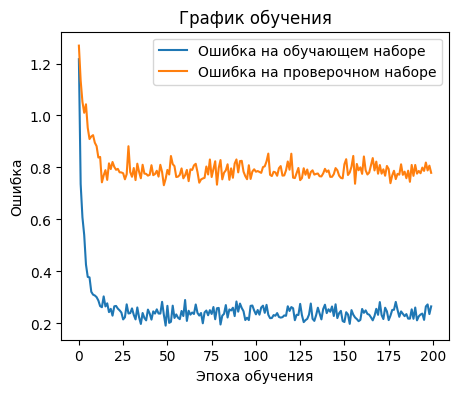

In [ ]:
# отображаем график ошибки обучения
plt.figure(figsize = (5, 4))
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.title('График обучения')
plt.legend()
plt.show()

In [ ]:
model.save('model1.h5')

## Модель 2 (Последовательная модель - ручная сборка)

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

25684

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 64)                652032    
                                                                 
 batch_normalization_11 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_12 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_30 (Dense)            (None, 10)                330       
                                                                 
 batch_normalization_13 (Bat  (None, 10)              

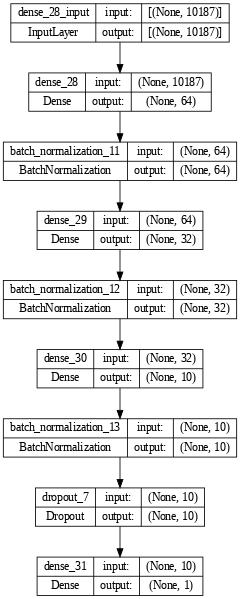

In [ ]:
# последовательная модель
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.2))
model.add(Dense(1, activation='linear'))

# компилируем
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae']) 

# отобразим данные модели
model.summary()
# отобразим схему модели
# plot_model(model, dpi=60, show_shapes=True)

In [ ]:
# обучаем модель
history = model.fit(x_train, # обучающая выборка вход
                    y_train, # обучающая выборка выход
                    epochs=200, # эпох
                    validation_data=(x_val,   # валидационная выборка вход
                                     y_val),  # валидационная выборка выход
                    verbose=0, # без вывода статуса обучения
                    batch_size=25, # размер батча
                    callbacks=[pltMae, checkpoint, lr_reduce], # колбэки early
                    )

3/3 [==============================] - 0s 3ms/step
Эпоха 0 модуль ошибки 1143.995
3/3 [==============================] - 0s 3ms/step
Эпоха 1 модуль ошибки 1135.602
3/3 [==============================] - 0s 3ms/step
Эпоха 2 модуль ошибки 1140.123
3/3 [==============================] - 0s 3ms/step
Эпоха 3 модуль ошибки 1123.202
3/3 [==============================] - 0s 3ms/step
Эпоха 4 модуль ошибки 1127.708
3/3 [==============================] - 0s 3ms/step
Эпоха 5 модуль ошибки 1139.305
3/3 [==============================] - 0s 3ms/step
Эпоха 6 модуль ошибки 1141.618
3/3 [==============================] - 0s 3ms/step
Эпоха 7 модуль ошибки 1141.944
3/3 [==============================] - 0s 3ms/step
Эпоха 8 модуль ошибки 1136.566
3/3 [==============================] - 0s 3ms/step
Эпоха 9 модуль ошибки 1125.322
3/3 [==============================] - 0s 3ms/step
Эпоха 10 модуль ошибки 1108.359
3/3 [==============================] - 0s 3ms/step
Эпоха 11 модуль ошибки 1080.281
3/3 [=========

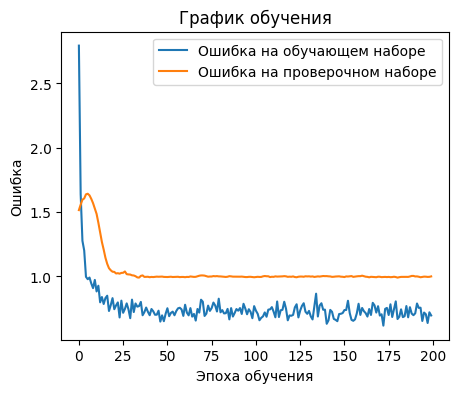

In [ ]:
# отображаем график ошибки обучения
plt.figure(figsize = (5, 4))
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.title('График обучения')
plt.legend()
plt.show()

## keras-tuner

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

1297983

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import pandas as pd

# создание модели
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i), 32, 256, 32), activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae'])
    return model

# tuner = RandomSearch(
#     build_model,
#     objective='val_loss',
#     max_trials=20,
#     executions_per_trial=3,
#     directory='my_dir',
#     project_name='citystar-Random')

tuner = Hyperband(build_model, 
                  objective='val_loss', 
                  max_epochs=10, 
                  factor=3, 
                  directory='my_dir', 
                  project_name='citystar-Hyperband')

# tuner = BayesianOptimization(
#     build_model,
#     objective='val_loss',
#     max_trials=20,
#     executions_per_trial=3,
#     directory='my_dir',
#     project_name='citystar-BayesianOptimization')

# !rm -rf my_dir

# Обучение модели
tuner.search(x_train, y_train, 
             epochs=10, validation_data=(x_val, y_val))

Trial 30 Complete [00h 00m 06s]
val_loss: 0.3683455288410187

Best val_loss So Far: 0.3437166213989258
Total elapsed time: 00h 02m 07s


In [ ]:
# Получение лучшей модели
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Оценка лучшей модели
eval_model(best_model)

Модуль ошибки 495.186


In [ ]:
# Построение модели на данных для вывода ее структуры
best_model.build((None, x_train.shape[1]))

# Сохраним модель
best_model.save('keras-tuner.h5')

# Вывод структуры лучшей модели
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                652032    
                                                                 
 dense_1 (Dense)             (None, 256)               16640     
                                                                 
 dense_2 (Dense)             (None, 192)               49344     
                                                                 
 dense_3 (Dense)             (None, 224)               43232     
                                                                 
 dense_4 (Dense)             (None, 224)               50400     
                                                                 
 dense_5 (Dense)             (None, 64)                14400     
                                                                 
 dense_6 (Dense)             (None, 64)                4

In [ ]:
# сводная информация о результатах поиска модели с помощью Keras Tuner.
tuner.results_summary()

Results summary
Results in my_dir/citystar-Hyperband
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0017 summary
Hyperparameters:
num_layers: 7
units_0: 64
units_1: 256
learning_rate: 0.001
units_2: 192
units_3: 224
units_4: 224
units_5: 64
units_6: 64
units_7: 160
units_8: 256
units_9: 32
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 0.3437166213989258

Trial 0014 summary
Hyperparameters:
num_layers: 4
units_0: 96
units_1: 128
learning_rate: 0.001
units_2: 128
units_3: 96
units_4: 32
units_5: 128
units_6: 192
units_7: 64
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0001
units_8: 192
units_9: 128
Score: 0.3650011122226715

Trial 0029 summary
Hyperparameters:
num_layers: 7
units_0: 128
units_1: 64
learning_rate: 0.0001
units_2: 192
units_3: 192
units_4: 32
units_5: 128
units_6: 160
units_7: 32
units_8: 128
units_9: 128
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/b

In [ ]:
# загрузим модель
model = load_model('model1.h5', compile = True)

print('Верный ответ:', 2850)
print('Прогноз:', get_price(model, 'Ленинский', 'Куйбышева', '1', 'раздельная', '3', '57', '35', \
                 'Трехкомнатная квартира нестандартной планировки (третья комната с отдельным входом) в нормальном состоянии, санузел раздельный, трубы пластиковые, водомеры. Первый этаж, высоко. В центре Ленинского района. Есть все: садики, школы, скверы и парки, магазины, поликлиника. Очень тихое, спокойное место.') )
print('Верный ответ:', '6990')
print('Прогноз:', get_price(model, 'Орджоникидзевский', '50-летия Магнитки', '3', 'нестандартная', '3', '98.5', '60', \
                 'Продам трехкомнатную квартиру 100кв.м. Просторная,светлая,уютная- встроенные удобные гардеробные, два больших балкона, кондиционер, водонагреватель, раздельный санузел, видео- звонок. Во дворе дома детский сад и школа. Остается мебель и кухонный гарнитур. В собственности более 5 лет. Долгов и обременений нет.Один собственник.') )
print('Верный ответ:', '5100')
print('Прогноз:', get_price(model, 'Ленинский', 'Менделеева', '3', 'старой планировки', '3', '83', '55', \
                 'ПРОДАМ трехкомнатную квартиру старой планировки в хорошем состоянии, раздельная. вся инфраструктура рядом. квартира в хорошем состоянии, пл.окна, водомеры, заменена эл.проводка, стены выровнены, натяжной потолок, м/двери, ламинат. с/у разд. в кафеле, душ.кабина, остается кухонный гарнитур, прихожая, холодильник, два кондиционера, стиральная машина. б/з. или ОБМЕНЯЮ на двухкомнатную квартиру старой планировки в Ленинском районе + ваша доплата. рассмотрю варианты') )


Верный ответ: 2850
Прогноз: 2890.0
Верный ответ: 6990
Прогноз: 7051.0
Верный ответ: 5100
Прогноз: 4748.0
